----------------------------------------------------------------------
----------------------------------------------------------------------
# Import dependencies

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

----------------------------------------------------------------------
----------------------------------------------------------------------
# Functions

Given a dataframe and name of a numerically represented categorical variable, alongwith a dictionary mapping numbers to strings and an optional order, this function converts a numerically represented categorical variable to a string represented categorical variable

In [2]:
def num_to_category(df, var, num_string_dict, order=None):
    categories = []
    ordered = False
    if order == None:
        ordered = False
        categories = []
        for key in sorted(num_string_dict.keys()): 
            categories.append(num_string_dict[key]) 
    else:
        ordered = True
        categories = order
    categoricaltype = pd.api.types.CategoricalDtype(categories=categories, ordered=ordered)
    df[var] = df[var].apply(lambda num: num_string_dict[num]).astype(categoricaltype)
    

Given a dataframe and a list of categorical variables, this function plots boxplots for the target variable cnt

In [3]:
def boxplots_for_cnt_vs_categoricalvariables(df, catvars):
    ncols = 3
    catvarslen = len(catvars)
    nrows = catvarslen/ncols if catvarslen%ncols==0 else catvarslen/ncols + 1
    
    plt.figure(figsize=[20,12])
    for ploti in range(catvarslen):
        plt.subplot(nrows, ncols, ploti + 1)
        ax = sns.boxplot(x=catvars[ploti], y="cnt", data=df)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  

Given a dataframe and categorical variables, this function creates dummy variables for each categorical variable and concatenates it to the original dataframe. It then drops the original categorical variables from the dataframe and returns the dataframe.

In [4]:
      
def concat_dummy_vars(df, catvars):
    for catvar in catvars:
        catvar_dummies = pd.get_dummies(df[catvar], drop_first=True)
        df = pd.concat([df, catvar_dummies], axis=1)
        df.drop(columns=[catvar], inplace=True)
        
    return df

Given a datframe and a y variable, the function returns a tuple with y variable and X variables.

In [5]:
def y_X(df, y):
    y_ = df.pop(y)
    X_ = df
    return (y_, X_)

Given a list of features to include in the model, a linear regression model is created from the training dataset.

In [6]:
def lr_model_train(support_cols):
    # Get the rfe supported columns filtered
    X_train_supportcols = X_train[support_cols]

    # Add constant for stats model preparation
    X_train_supportcols_sm = sm.add_constant(X_train_supportcols)

    # Select a cost function
    costfunc = sm.OLS(y_train, X_train_supportcols_sm)

    # Fit the model
    lr_model = costfunc.fit()
    
    return lr_model

Given a list of features to include in the model, a linear regression model is created from the training dataset, and a summary of the learned model is returned.

In [7]:
def lr_model_train_summarize(support_cols):
    lr_model = lr_model_train(support_cols)

    # Summary
    return lr_model.summary()

Eliminates the given variable from the `supported_cols` and then trains and summarizes a linear regression model.

In [8]:
def eliminate_train_summarize(var):
    supported_cols.remove(var)
    return lr_model_train_summarize(supported_cols)

Prepares a sorted VIF table with descending VIF values for the features in the `supported_cols`

In [9]:
def prepare_VIF_table_supportedcols():
    vif = pd.DataFrame()

    vif["Features"] = supported_cols
    X_train_supcols = X_train[supported_cols]
    vif["VIF"] = [variance_inflation_factor(X_train_supcols.values, i) for i in range(X_train_supcols.shape[1])]
    vif["VIF"] = round(vif["VIF"], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    return vif

Given a feature, it is reinstated into the `supported_cols` and a linear regression model is trained and summarized.

In [10]:
def reinstate_train_summarize(var):
    supported_cols.append(var)
    return lr_model_train_summarize(supported_cols)

----------------------------------------------------------------------
----------------------------------------------------------------------
# Load dataset
- Read the csv into dataset.
- Get some metadata insights.

## Read the csv into dataset.

In [11]:
day = pd.read_csv("day.csv")
day.shape

(730, 16)

In [12]:
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


##  Get some metadata insights.

In [13]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
instant       730 non-null int64
dteday        730 non-null object
season        730 non-null int64
yr            730 non-null int64
mnth          730 non-null int64
holiday       730 non-null int64
weekday       730 non-null int64
workingday    730 non-null int64
weathersit    730 non-null int64
temp          730 non-null float64
atemp         730 non-null float64
hum           730 non-null float64
windspeed     730 non-null float64
casual        730 non-null int64
registered    730 non-null int64
cnt           730 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


No null values found

In [14]:
day.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


# Checkpoint 1: Load dataset

----------------------------------------------------------------------
----------------------------------------------------------------------
# Step 1: Reading and understanding the data
- Understanding the data dictionary.
    - Identify the categorical and numerical columns.
    - Drop columns not required in the analysis.
    - Create a new index if possible.
- Modify categorical variables if necessary, to meet the requirements of the analysis.

## Understanding the data dictionary.
- Identify the categorical and numerical columns.
- Drop columns not required in the analysis.
- Create a new index if possible.

Data Dictionary:
- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : temperature in Celsius
- atemp: feeling temperature in Celsius
- hum: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

### Identify the categorical and numerical columns.

#### Categorical variables
- `season`
- `yr`
- `mnth`
- `holiday`
- `weekday`
- `workingday`
- `weathersit`

#### Numerical variables
- `temp`
- `atemp`
- `hum`
- `windspeed`
- `casual`
- `registered`

### Drop columns not required in the analysis.
Columns and reasons to drop:
- `dteday`: Most the of the date components are available in other variables like yr, mnth etc
- `atemp`: It is similar to the temp variable
- `casual`: It is a component of the target variable cnt
- `registered`: It is a component of the target variable cnt

In [15]:
day.drop(columns=["dteday", "atemp", "casual", "registered"], inplace=True)

### Create a new index if possible.
- `instant` is mentioned as record index, so lets replace it as the index after checking for number of unique values

In [16]:
day.instant.nunique() == day.shape[0]

True

`instant` has number of unique values equal to number of rows and hence can safely be used as index

In [17]:
day.set_index(keys=["instant"], drop=True, inplace=True)
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
instant,,,,,,,,,,,
1,1,0,1,0,6,0,2,14.110847,80.5833,10.749882,985
2,1,0,1,0,0,0,2,14.902598,69.6087,16.652113,801
3,1,0,1,0,1,1,1,8.050924,43.7273,16.636703,1349
4,1,0,1,0,2,1,1,8.200000,59.0435,10.739832,1562
5,1,0,1,0,3,1,1,9.305237,43.6957,12.522300,1600


## Modify categorical variables if necessary, to meet the requirements of the analysis.
- `season`: (1:spring, 2:summer, 3:fall, 4:winter)
- `mnth`: num to mnth
- `weekday`: find num to weekday
- `weathersit`:
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

`season`:

In [18]:
num_season_dictionary = {1:"spring", 
                         2:"summer", 
                         3:"fall", 
                         4:"winter"}

num_to_category(day, "season", num_season_dictionary)

`mnth`:

In [19]:
num_month_dictionary = {1: "January", 
                        2: "February", 
                        3: "March", 
                        4: "April", 
                        5: "May", 
                        6: "June",
                        7: "July", 
                        8: "August", 
                        9: "September",
                        10: "October", 
                        11: "November", 
                        12: "December"}
order = [num_month_dictionary[num] for num in sorted(num_month_dictionary.keys())]
num_to_category(day, "mnth", num_month_dictionary, order=order)

`weekday`:

In [20]:
# Find day from the date of first record and also the weekday variable is 6
# For 1st record date is 01-01-2018
# Find day for mapping numbers
# The day for 01-01-2018 is mapped to number 6
datetime.strptime("01-01-2018", "%d-%m-%Y").strftime("%A")

'Monday'

Assuming the following encodings upon the findings above that 6 is Monday
- `0`\- `Tuesday`
- `1`\- `Wednesday`
- `2`\- `Thursday`
- `3`\- `Friday`
- `4`\- `Saturday`
- `5`\- `Sunday`
- `6`\- `Monday`


In [21]:
num_weekday_dictionary = {0: "Tuesday", 
                          1: "Wednesday", 
                          2: "Thursday", 
                          3: "Friday", 
                          4: "Saturday", 
                          5: "Sunday",
                          6: "Monday"}
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
num_to_category(day, "weekday", num_weekday_dictionary, order=order)

`weathersit`:

In [22]:
num_weathersit_dictionary = {1: "Clear",
                             2: "Cloudy",
                             3: "Light Rain",
                             4: "Heavy Rain"}
num_to_category(day, "weathersit", num_weathersit_dictionary)

In [23]:
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
instant,,,,,,,,,,,
1,spring,0,January,0,Monday,0,Cloudy,14.110847,80.5833,10.749882,985
2,spring,0,January,0,Tuesday,0,Cloudy,14.902598,69.6087,16.652113,801
3,spring,0,January,0,Wednesday,1,Clear,8.050924,43.7273,16.636703,1349
4,spring,0,January,0,Thursday,1,Clear,8.200000,59.0435,10.739832,1562
5,spring,0,January,0,Friday,1,Clear,9.305237,43.6957,12.522300,1600


In [24]:
day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 11 columns):
season        730 non-null category
yr            730 non-null int64
mnth          730 non-null category
holiday       730 non-null int64
weekday       730 non-null category
workingday    730 non-null int64
weathersit    730 non-null category
temp          730 non-null float64
hum           730 non-null float64
windspeed     730 non-null float64
cnt           730 non-null int64
dtypes: category(4), float64(3), int64(4)
memory usage: 49.6 KB


# Checkpoint 2: Reading and understanding the data

----------------------------------------------------------------------
----------------------------------------------------------------------
# Step 2: Visualising the data
- Pair plot for numerical data
- Boxplots for categorical data

## Pair plot for numerical data

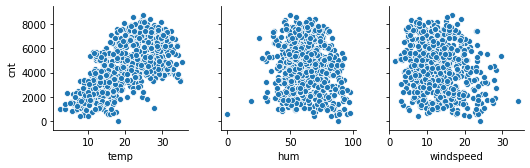

In [25]:
sns.pairplot(y_vars="cnt", x_vars=["temp","hum","windspeed"], data=day)
plt.show()

### Observations from pairplots:
- As `temp` i.e. temperature rose, people opted renting bikes i.e number of rentals increased with increase in temperature
- As `hum` increases there is a slight drop in the number of rentals.

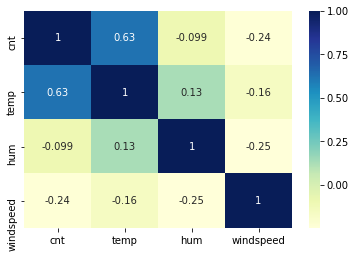

In [26]:
sns.heatmap(day[["cnt", "temp", "hum", "windspeed"]].corr(), annot=True, cmap="YlGnBu")

### Observations from heatmap:
- `temp` has the maximum correlation with the target variable `cnt`

## Boxplots for categorical data

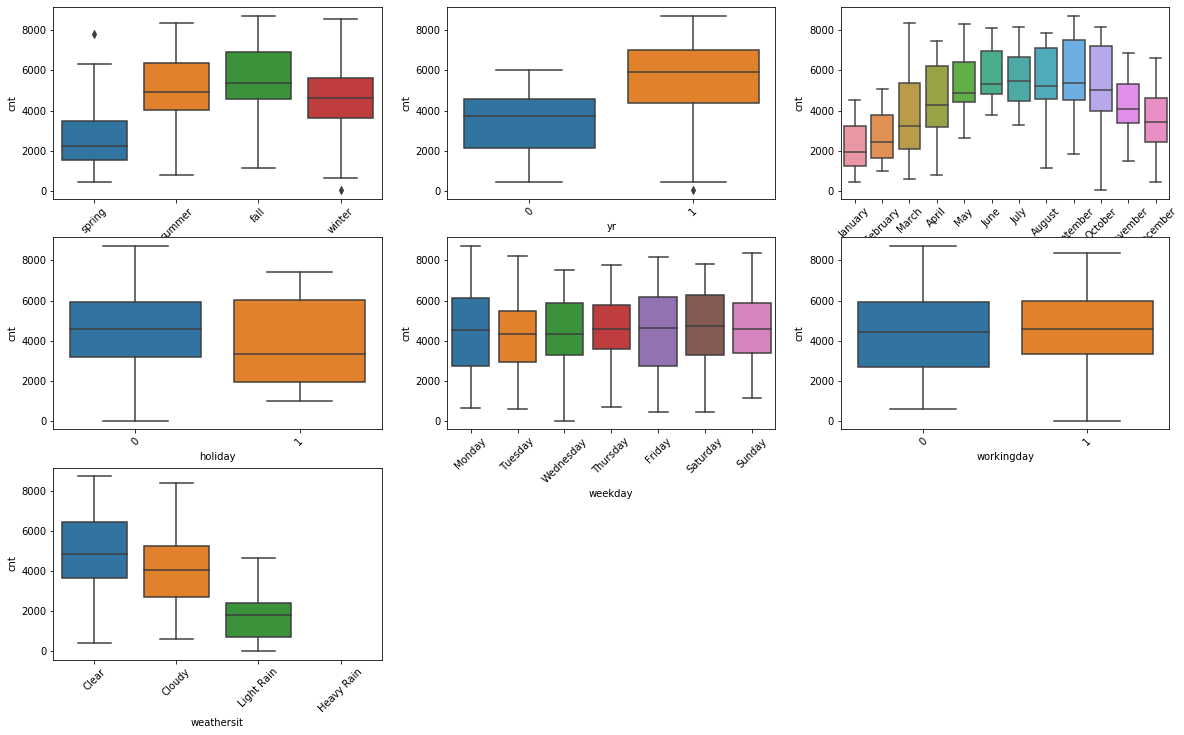

In [27]:
boxplots_for_cnt_vs_categoricalvariables(day, ["season","yr","mnth","holiday","weekday","workingday","weathersit"])

### Observations from boxplots:
- Summer and Fall `season` have distributions at higher end for number of rentals(Typically these seasons also have higher temperatures). So there could be some sort of collinearity between temp and season
- Again it is evident that `yr` 2019 had distributions at higher end for number of rentals than those in 2018.
- Again the `mnth` of April to November have distributions at higher end for number of rentals.(Typically these months also overlap the summer and fall seasons). Also the months associated with fall i.e. Sept to Nov have larger range for the number of rentals.
    - Spring runs from March 1 to May 31;
    - Summer runs from June 1 to August 31;
    - Fall (autumn) runs from September 1 to November 30; and.
- On `holiday` the min number of rentals is larger than the min of number of rentals for non holiday days.
- As the `weathersit` shifts from Clear to Rainy the distributions of rentals drop to the lower end and in heavy rains the rentals drop to 0. This is explained easily as people avoid bikes on rainy days.

# Checkpoint 3: Step 2: Visualising the data

----------------------------------------------------------------------
----------------------------------------------------------------------
# Step 3: Data preparation
1. Encoding.
    - Convert binary categorical variables into 1/0
    - Convert non binary categorical variables into dummy numeric variables and drop original categorical variables.
2. Plot heatmap to find any correlations.
3. Splitting data into train and test.
4. Scaling the data.
    - 3.1 Scale the train data.
    - 3.2 Transform the test data to fit the scale of the train data
5. Split the train and test data into y and X.

In [28]:
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
instant,,,,,,,,,,,
1,spring,0,January,0,Monday,0,Cloudy,14.110847,80.5833,10.749882,985
2,spring,0,January,0,Tuesday,0,Cloudy,14.902598,69.6087,16.652113,801
3,spring,0,January,0,Wednesday,1,Clear,8.050924,43.7273,16.636703,1349
4,spring,0,January,0,Thursday,1,Clear,8.200000,59.0435,10.739832,1562
5,spring,0,January,0,Friday,1,Clear,9.305237,43.6957,12.522300,1600


## 1. Encoding

### Convert binary categorical variables into 1/0

Binary categorical variables:
- `yr`
- `holiday`
- `workingday`

`yr` :
- `0`: 2018
- `1`: 2019


In [29]:
day.yr.value_counts()

1    365
0    365
Name: yr, dtype: int64

`holiday`:
- `0`: Not a holiday
- `1`: A holiday

In [30]:
day.holiday.value_counts()

0    709
1     21
Name: holiday, dtype: int64

`workingday`:
- `0`: A non working day i.e. a holiday or weekend
- `1`: A workingday

In [31]:
day.workingday.value_counts()

1    499
0    231
Name: workingday, dtype: int64

The categorical binary variables `yr`, `holiday` and `workingday` are already encoded for 1/0

### Convert non binary categorical variables into dummy numeric variables and drop original categorical variables.

Non binary categorical variables:
- `season`
- `mnth`
- `weekday`
- `weathersit`

In [32]:
day.shape

(730, 11)

`season`:
- `000` - `spring`
- `100` - `summer`
- `010` - `fall`
- `001` - `winder`

`mnth`:
- `00000000000`: `January`
- `10000000000`: `February`
- `01000000000`: `March`
- `00100000000`: `April`
- `00010000000`: `May`
- `00001000000`: `June`
- `00000100000`: `July`
- `00000010000`: `August`
- `00000001000`: `September`
- `00000000100`: `October`
- `00000000010`: `November`
- `00000000001`: `December`


`weekday`:
- `000000` - `Monday`
- `100000` - `Tuesday`
- `010000` - `Wednesday`
- `001000` - `Thursday`
- `000100` - `Friday`
- `000010` - `Saturday`
- `000001` - `Sunday`

`weathersit`:
- `000` - `Clear`
- `100` - `Cloudy`
- `010` - `Light Rain`
- `001` - `Heavy Rain`

In [33]:
day = concat_dummy_vars(day, ['season', 'mnth', 'weekday', 'weathersit'])

In [34]:
day.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,summer,fall,winter,...,December,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Cloudy,Light Rain,Heavy Rain
instant,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,14.110847,80.5833,10.749882,985,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,14.902598,69.6087,16.652113,801,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,0,1,8.050924,43.7273,16.636703,1349,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,8.200000,59.0435,10.739832,1562,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0,0,1,9.305237,43.6957,12.522300,1600,0,0,0,...,0,0,0,0,1,0,0,0,0,0


- Before adding dummy variables: 11 columns
- Removed 4 cat vars: 11 - 4 = 7 columns
- Dummy vards added 3 + 11 + 6 + 3 = 23 columns
- Total columns after adding dummy var = 7 + 23 = 30 columns

In [35]:
day.shape

(730, 30)

In [36]:
day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 30 columns):
yr            730 non-null int64
holiday       730 non-null int64
workingday    730 non-null int64
temp          730 non-null float64
hum           730 non-null float64
windspeed     730 non-null float64
cnt           730 non-null int64
summer        730 non-null uint8
fall          730 non-null uint8
winter        730 non-null uint8
February      730 non-null uint8
March         730 non-null uint8
April         730 non-null uint8
May           730 non-null uint8
June          730 non-null uint8
July          730 non-null uint8
August        730 non-null uint8
September     730 non-null uint8
October       730 non-null uint8
November      730 non-null uint8
December      730 non-null uint8
Tuesday       730 non-null uint8
Wednesday     730 non-null uint8
Thursday      730 non-null uint8
Friday        730 non-null uint8
Saturday      730 non-null uint8
Sunday        730 non-null uint

All columns are numerical. So we have the dataset ready for linear regression modelling.

## 2. Plot heatmap to find any correlations and multicollinearities

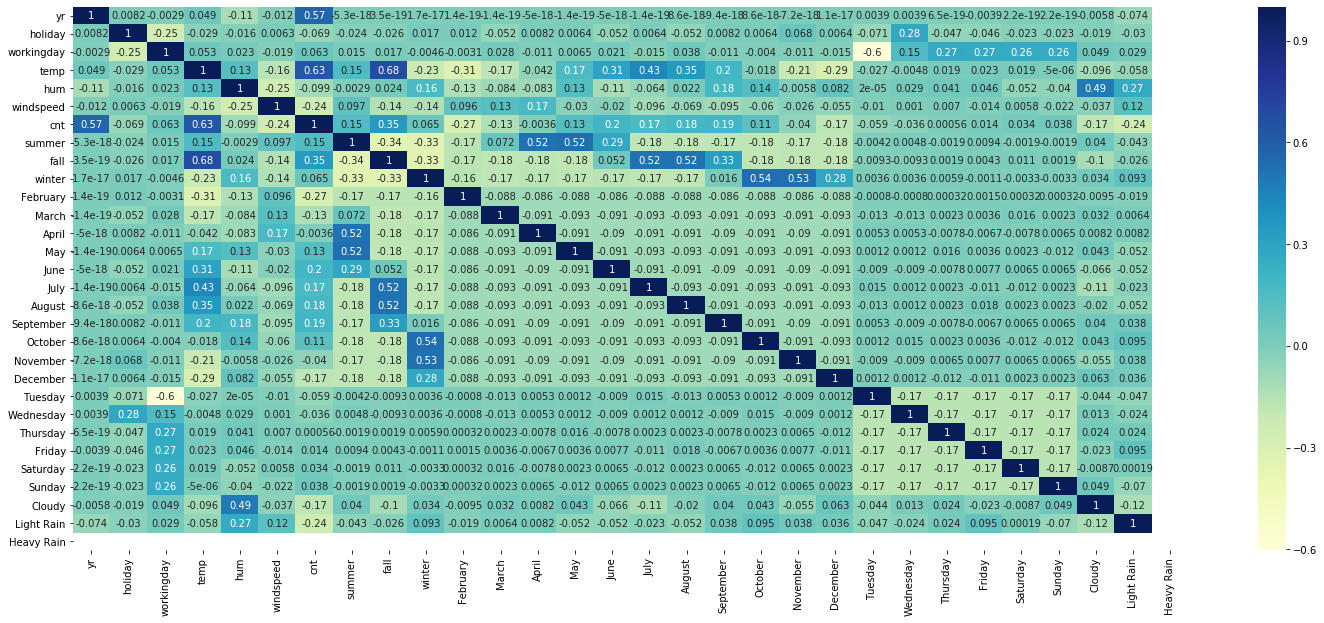

In [37]:
plt.figure(figsize=[25,10])
sns.heatmap(day.corr(), annot=True, cmap="YlGnBu")
plt.show()

Multicollinearities are observerd between many combinations of variables

## 3. Splitting data into train and test.

In [38]:
day_train, day_test = train_test_split(day, train_size=0.7, random_state=100)
print(day_train.shape)
print(day_test.shape)

(510, 30)
(220, 30)


## 4. Scaling the data.
    4.1 Scale the train data.
    4.2 Scale the test data to fit the scale of the train data

### 4.1 Scale the train data.

In [39]:
day_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,summer,fall,winter,...,December,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Cloudy,Light Rain,Heavy Rain
instant,,,,,,,,,,,,,,,,,,,,,
577,1,0,1,29.246653,70.4167,11.083475,7216,0,1,0,...,0,0,0,1,0,0,0,0,0,0
427,1,0,0,16.980847,62.1250,10.792293,4066,0,0,0,...,0,0,0,0,0,0,0,1,0,0
729,1,0,0,10.489153,48.3333,23.500518,1796,0,0,0,...,1,1,0,0,0,0,0,0,0,0
483,1,0,0,15.443347,48.9583,8.708325,4220,1,0,0,...,0,0,0,0,0,0,0,1,0,0
112,0,0,1,13.803347,72.9583,14.707907,1683,1,0,0,...,0,0,0,0,0,0,1,1,0,0


In [40]:
# Create scaler
scaler = MinMaxScaler()

# Create a list of continuous numeric vars that need scaling
scale_vars = ["temp", "hum", "windspeed", "cnt"]

# Fit and transform train data
day_train[scale_vars] = scaler.fit_transform(day_train[scale_vars])
day_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,summer,fall,winter,...,December,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Cloudy,Light Rain,Heavy Rain
instant,,,,,,,,,,,,,,,,,,,,,
577,1,0,1,0.815169,0.725633,0.264686,0.827658,0,1,0,...,0,0,0,1,0,0,0,0,0,0
427,1,0,0,0.442393,0.640189,0.255342,0.465255,0,0,0,...,0,0,0,0,0,0,0,1,0,0
729,1,0,0,0.245101,0.498067,0.663106,0.204096,0,0,0,...,1,1,0,0,0,0,0,0,0,0
483,1,0,0,0.395666,0.504508,0.188475,0.482973,1,0,0,...,0,0,0,0,0,0,0,1,0,0
112,0,0,1,0.345824,0.751824,0.380981,0.191095,1,0,0,...,0,0,0,0,0,0,1,1,0,0


In [41]:
day_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,summer,fall,winter,...,December,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Cloudy,Light Rain,Heavy Rain
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.0
mean,0.507843,0.025490,0.676471,0.537440,0.650480,0.320883,0.513499,0.247059,0.262745,0.247059,...,0.084314,0.143137,0.150980,0.131373,0.158824,0.133333,0.127451,0.345098,0.029412,0.0
std,0.500429,0.157763,0.468282,0.225858,0.145846,0.169803,0.224421,0.431725,0.440557,0.431725,...,0.278131,0.350557,0.358381,0.338139,0.365870,0.340268,0.333805,0.475867,0.169124,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.339853,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.000000,0.000000,1.000000,0.542596,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,1.000000,0.000000,1.000000,0.735215,0.754830,0.414447,0.684710,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


### 4.2 Scale the test data to fit the scale of the train data

In [42]:
day_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,summer,fall,winter,...,December,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Cloudy,Light Rain,Heavy Rain
instant,,,,,,,,,,,,,,,,,,,,,
185,0,1,0,29.793347,63.7917,5.459106,6043,0,1,0,...,0,0,1,0,0,0,0,1,0,0
536,1,0,1,32.082500,59.2083,7.625404,6211,1,0,0,...,0,0,0,0,1,0,0,0,0,0
300,0,0,1,19.270000,81.2917,13.250121,2659,0,0,1,...,0,0,0,0,0,1,0,1,0,0
222,0,0,1,31.433347,42.4167,13.417286,4780,0,1,0,...,0,0,0,0,1,0,0,0,0,0
153,0,0,1,29.315000,30.5000,19.583229,4968,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [43]:
# Scale the test data
day_test[scale_vars] = scaler.transform(day_test[scale_vars])

In [44]:
day_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,summer,fall,winter,...,December,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Cloudy,Light Rain,Heavy Rain
instant,,,,,,,,,,,,,,,,,,,,,
185,0,1,0,0.831783,0.657364,0.084219,0.692706,0,1,0,...,0,0,1,0,0,0,0,1,0,0
536,1,0,1,0.901354,0.610133,0.153728,0.712034,1,0,0,...,0,0,0,0,1,0,0,0,0,0
300,0,0,1,0.511964,0.837699,0.334206,0.303382,0,0,1,...,0,0,0,0,0,1,0,1,0,0
222,0,0,1,0.881625,0.437098,0.339570,0.547400,0,1,0,...,0,0,0,0,1,0,0,0,0,0
153,0,0,1,0.817246,0.314298,0.537414,0.569029,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [45]:
day_test.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,summer,fall,winter,...,December,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Cloudy,Light Rain,Heavy Rain
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0
mean,0.481818,0.036364,0.700000,0.558718,0.638221,0.313293,0.522154,0.263636,0.245455,0.236364,...,0.086364,0.145455,0.127273,0.168182,0.100000,0.163636,0.177273,0.318182,0.027273,0.0
std,0.500809,0.187620,0.459303,0.233187,0.148694,0.159584,0.219163,0.441609,0.431338,0.425817,...,0.281541,0.353363,0.334038,0.374881,0.300684,0.370789,0.382770,0.466833,0.163248,0.0
min,0.000000,0.000000,0.000000,0.046591,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.355429,0.529197,0.198843,0.378595,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,1.000000,0.558172,0.625590,0.300126,0.524678,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,1.000000,0.000000,1.000000,0.755981,0.743798,0.402718,0.677750,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,0.984424,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


## 5. Split the train and test data into y and X.

In [46]:
# Split the train and test data into y and X
y_train, X_train = y_X(day_train, y='cnt')
y_test, X_test = y_X(day_test, y='cnt')

We have successfully prepared the train and test set

# Checkpoint 4 : Step 3: Data preparation

----------------------------------------------------------------------
----------------------------------------------------------------------
# Build the model 
1. Build a model by using RFE for 15 best features.
2. Eliminate features manually to get a leaner model.

## 1. Build a model by using RFE for 15 best features.

In [47]:
# Create a linear regression instance
lr = LinearRegression()
# Fit a model on the train set
lr.fit(X_train, y_train)

# Get top 15 best features using RFE
rfe = RFE(lr, 15)
rfe = rfe.fit(X_train, y_train)

In [48]:
rfe_out = pd.DataFrame({"Features": X_train.columns, "Support": rfe.support_, "Ranking": rfe.ranking_})
rfe_out.sort_values(by="Ranking")

,Features,Support,Ranking
0,yr,True,1
16,September,True,1
15,August,True,1
27,Light Rain,True,1
10,March,True,1
17,October,True,1
8,winter,True,1
20,Tuesday,True,1
6,summer,True,1
5,windspeed,True,1


In [49]:
supported_cols = list(rfe_out[rfe_out.Support].Features)
print(supported_cols)

['yr', 'holiday', 'temp', 'hum', 'windspeed', 'summer', 'fall', 'winter', 'March', 'August', 'September', 'October', 'Tuesday', 'Cloudy', 'Light Rain']


We have found the top 15 features now

Lets calculate statistics for the mode

In [50]:
# Train models with the rfe supported features
lr_model_train_summarize(supported_cols)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     185.0
Date:                Fri, 11 Jun 2021   Prob (F-statistic):          1.42e-191
Time:                        21:15:55   Log-Likelihood:                 520.78
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     494   BIC:                            -941.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2351      0.027      8.757      0.000       0.182       0.288
yr             0.2300      0.008     28.817      0.000       0.214       0.246
holiday       -0.0976      0.025     -3.870      0.000      -0.147      -0.048
temp           0.4937      0.034     14.734      0.000       0.428       0.559
hum           -0.1620      0.037     -4.353      0.000      -0.235      -0.089
windspeed     -0.1837      0.025     -7.260      0.000      -0.233      -0.134
summer         0.1220      0.015      8.225      0.000       0.093       0.151
fall           0.0371      0.022      1.660      0.097      -0.007       0.081
winter         0.1498      0.014     10.804      0.000       0.123       0.177
March          0.0256      0.014      1.792      0.074      -0.002       0.054
August         0.0474      0.017      2.748      0.006       0.014       0.081
September      0.1174      0.017      6.881      0.000       0.084       0.151
October        0.0422      0.017      2.428      0.016       0.008       0.076
Tuesday       -0.0452      0.011     -3.992      0.000      -0.067      -0.023
Cloudy        -0.0579      0.010     -5.596      0.000      -0.078      -0.038
Light Rain    -0.2530      0.026     -9.678      0.000      -0.304      -0.202
==============================================================================
Omnibus:                       76.120   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.351
Skew:                          -0.749   Prob(JB):                     1.40e-43
Kurtosis:                       5.654   Cond. No.                         19.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Observations for model fitted using the supported columns provided by RFE:
- R-squared: 0.849 : `Good` as it is `high`
- Adj. R-squared: 0.844 : `Good` as it is `high`
- Prob (F-statistic): 1.42e-191 < 0.05: `Good` as it is `low`
- Pvals of the coefficients:
    - `fall`: 0.097 > 0.05 : `Bad` as it is `high`

## 2. Eliminate features manually to get a leaner model.

### Eliminate `fall` as it has high p value and again fit a model

In [51]:
# Eliminate fall and train model and summarize
eliminate_train_summarize("fall")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     197.3
Date:                Fri, 11 Jun 2021   Prob (F-statistic):          3.88e-192
Time:                        21:15:55   Log-Likelihood:                 519.36
No. Observations:                 510   AIC:                            -1009.
Df Residuals:                     495   BIC:                            -945.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2355      0.027      8.755      0.000       0.183       0.288
yr             0.2289      0.008     28.729      0.000       0.213       0.245
holiday       -0.0993      0.025     -3.933      0.000      -0.149      -0.050
temp           0.5354      0.022     24.123      0.000       0.492       0.579
hum           -0.1709      0.037     -4.634      0.000      -0.243      -0.098
windspeed     -0.1874      0.025     -7.418      0.000      -0.237      -0.138
summer         0.1049      0.011      9.796      0.000       0.084       0.126
winter         0.1386      0.012     11.414      0.000       0.115       0.162
March          0.0208      0.014      1.487      0.138      -0.007       0.048
August         0.0578      0.016      3.580      0.000       0.026       0.089
September      0.1267      0.016      7.851      0.000       0.095       0.158
October        0.0383      0.017      2.220      0.027       0.004       0.072
Tuesday       -0.0450      0.011     -3.967      0.000      -0.067      -0.023
Cloudy        -0.0567      0.010     -5.483      0.000      -0.077      -0.036
Light Rain    -0.2480      0.026     -9.533      0.000      -0.299      -0.197
==============================================================================
Omnibus:                       68.451   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.099
Skew:                          -0.696   Prob(JB):                     5.19e-37
Kurtosis:                       5.435   Cond. No.                         18.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Observations for model after manually eliminating `fall`:
- R-squared: 0.848 : `Good` as it is `high`
- Adj. R-squared: 0.844 : `Good` as it is `high` and almost equal to previous model
- Prob (F-statistic): 3.88e-192 < 0.05: `Good` as it is `low`
- Pvals of the coefficients:
    - `March`: 0.138 > 0.05: `Bad` as it is `high`

### Eliminate `March` as it has high p value and again fit a model

In [52]:
# Eliminate March and train model and summarize
eliminate_train_summarize("March")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     211.8
Date:                Fri, 11 Jun 2021   Prob (F-statistic):          7.84e-193
Time:                        21:15:55   Log-Likelihood:                 518.22
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     496   BIC:                            -949.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2413      0.027      9.055      0.000       0.189       0.294
yr             0.2290      0.008     28.715      0.000       0.213       0.245
holiday       -0.1015      0.025     -4.025      0.000      -0.151      -0.052
temp           0.5304      0.022     24.144      0.000       0.487       0.574
hum           -0.1719      0.037     -4.655      0.000      -0.244      -0.099
windspeed     -0.1851      0.025     -7.334      0.000      -0.235      -0.136
summer         0.1048      0.011      9.776      0.000       0.084       0.126
winter         0.1351      0.012     11.330      0.000       0.112       0.158
August         0.0560      0.016      3.475      0.001       0.024       0.088
September      0.1253      0.016      7.767      0.000       0.094       0.157
October        0.0386      0.017      2.236      0.026       0.005       0.072
Tuesday       -0.0458      0.011     -4.033      0.000      -0.068      -0.023
Cloudy        -0.0566      0.010     -5.473      0.000      -0.077      -0.036
Light Rain    -0.2467      0.026     -9.477      0.000      -0.298      -0.196
==============================================================================
Omnibus:                       67.980   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.838
Skew:                          -0.674   Prob(JB):                     1.08e-38
Kurtosis:                       5.532   Cond. No.                         18.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Observations for model after manually eliminating `March`:
- R-squared: 0.847 : `Good` as it is `high`
- Adj. R-squared: 0.843 : `Good` as it is `high` and almost equal to previous model
- Prob (F-statistic): 7.84e-193 < 0.05: `Good` as it is `low`
- Pvals of the coefficients:
    - All p values look good as they are below 0.05

Perfrom VIF analysis to detect multicollinearity

In [53]:
prepare_VIF_table_supportedcols()

,Features,VIF
3,hum,14.65
2,temp,9.88
4,windspeed,3.59
6,winter,2.25
11,Cloudy,2.15
0,yr,2.02
5,summer,1.84
7,August,1.60
9,October,1.60
8,September,1.34


Observations for VIF:
- `hum`: 14.65 > 10 : `Bad` as very `high`

### Eliminate `hum` as it has high VIF

In [54]:
# Eliminate hum and train model and summarize
eliminate_train_summarize("hum")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     218.6
Date:                Fri, 11 Jun 2021   Prob (F-statistic):          2.00e-189
Time:                        21:15:55   Log-Likelihood:                 507.32
No. Observations:                 510   AIC:                            -988.6
Df Residuals:                     497   BIC:                            -933.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1431      0.017      8.606      0.000       0.110       0.176
yr             0.2328      0.008     28.758      0.000       0.217       0.249
holiday       -0.1035      0.026     -4.021      0.000      -0.154      -0.053
temp           0.5099      0.022     23.214      0.000       0.467       0.553
windspeed     -0.1519      0.025     -6.147      0.000      -0.200      -0.103
summer         0.1018      0.011      9.316      0.000       0.080       0.123
winter         0.1268      0.012     10.542      0.000       0.103       0.150
August         0.0542      0.016      3.299      0.001       0.022       0.087
September      0.1186      0.016      7.232      0.000       0.086       0.151
October        0.0344      0.018      1.955      0.051      -0.000       0.069
Tuesday       -0.0493      0.012     -4.265      0.000      -0.072      -0.027
Cloudy        -0.0841      0.009     -9.684      0.000      -0.101      -0.067
Light Rain    -0.2929      0.025    -11.931      0.000      -0.341      -0.245
==============================================================================
Omnibus:                       66.333   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.035
Skew:                          -0.659   Prob(JB):                     1.20e-37
Kurtosis:                       5.503   Cond. No.                         10.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Observations for model after manually eliminating `hum`:
- R-squared: 0.841 : `Good` as it is `high`
- Adj. R-squared: 0.837 : `Good` as it is `high` and almost equal to previous model
- Prob (F-statistic): 2.00e-189 < 0.05: `Good` as it is `low`
- Pvals of the coefficients:
    - `October`: 0.051 > 0.05: `Bad` as it is `high`

### Eliminate `October` as it has high p value

In [55]:
# Eliminate October and train model and summarize
eliminate_train_summarize("October")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     236.8
Date:                Fri, 11 Jun 2021   Prob (F-statistic):          8.46e-190
Time:                        21:15:55   Log-Likelihood:                 505.37
No. Observations:                 510   AIC:                            -986.7
Df Residuals:                     498   BIC:                            -935.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1387      0.017      8.394      0.000       0.106       0.171
yr             0.2325      0.008     28.639      0.000       0.217       0.248
holiday       -0.1044      0.026     -4.047      0.000      -0.155      -0.054
temp           0.5181      0.022     23.965      0.000       0.476       0.561
windspeed     -0.1497      0.025     -6.048      0.000      -0.198      -0.101
summer         0.1002      0.011      9.173      0.000       0.079       0.122
winter         0.1384      0.011     13.172      0.000       0.118       0.159
August         0.0512      0.016      3.123      0.002       0.019       0.083
September      0.1137      0.016      6.996      0.000       0.082       0.146
Tuesday       -0.0483      0.012     -4.172      0.000      -0.071      -0.026
Cloudy        -0.0831      0.009     -9.563      0.000      -0.100      -0.066
Light Rain    -0.2872      0.024    -11.749      0.000      -0.335      -0.239
==============================================================================
Omnibus:                       58.082   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.254
Skew:                          -0.602   Prob(JB):                     9.52e-31
Kurtosis:                       5.249   Cond. No.                         10.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Observations for model after manually eliminating `October`:
- R-squared: 0.839 : `Good` as it is `high`
- Adj. R-squared: 0.836 : `Good` as it is `high` and almost equal to previous model
- Prob (F-statistic): 8.46e-190 < 0.05: `Good` as it is `low`
- Pvals of the coefficients:
    - All p values look good as they are below 0.05

Perfrom VIF analysis to detect multicollinearity

In [56]:
prepare_VIF_table_supportedcols()

,Features,VIF
2,temp,5.09
3,windspeed,3.13
0,yr,2.00
4,summer,1.82
6,August,1.59
5,winter,1.49
9,Cloudy,1.49
7,September,1.31
8,Tuesday,1.17
10,Light Rain,1.08


Observations for VIF:
- `temp`: 5.09 > 5 : `Not Bad` as very `medium`
- Lets eliminate `temp` and verify if it should be considered by comparing the various matrices like R2-squared, Adjusted R2-square etc.

In [57]:
### Eliminate `temp` as it has high VIF
eliminate_train_summarize("temp")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     94.46
Date:                Fri, 11 Jun 2021   Prob (F-statistic):          2.42e-108
Time:                        21:15:55   Log-Likelihood:                 309.79
No. Observations:                 510   AIC:                            -597.6
Df Residuals:                     499   BIC:                            -551.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4132      0.017     23.668      0.000       0.379       0.448
yr             0.2501      0.012     21.106      0.000       0.227       0.273
holiday       -0.1320      0.038     -3.493      0.001      -0.206      -0.058
windspeed     -0.2481      0.036     -6.932      0.000      -0.318      -0.178
summer         0.1667      0.015     10.761      0.000       0.136       0.197
winter         0.1180      0.015      7.688      0.000       0.088       0.148
August         0.2202      0.022     10.135      0.000       0.177       0.263
September      0.2332      0.023     10.285      0.000       0.189       0.278
Tuesday       -0.0459      0.017     -2.705      0.007      -0.079      -0.013
Cloudy        -0.1129      0.013     -8.958      0.000      -0.138      -0.088
Light Rain    -0.2877      0.036     -8.028      0.000      -0.358      -0.217
==============================================================================
Omnibus:                        1.815   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.403   Jarque-Bera (JB):                1.678
Skew:                           0.062   Prob(JB):                        0.432
Kurtosis:                       3.253   Cond. No.                         8.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Observations for model after manually eliminating `temp`:
- R-squared: 0.654 : `Bad` as it is went significantly low after eliminating `temp`
- Adj. R-squared:  0.647 : `Bad` as it went significantly low after eliminating `temp`
- Prob (F-statistic): 2.42e-108 < 0.05: `Good` as it is `low`
- Pvals of the coefficients:
    - All p values look good as they are below 0.05

Reinstate `temp` and summarize

In [58]:
reinstate_train_summarize("temp")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     236.8
Date:                Fri, 11 Jun 2021   Prob (F-statistic):          8.46e-190
Time:                        21:15:55   Log-Likelihood:                 505.37
No. Observations:                 510   AIC:                            -986.7
Df Residuals:                     498   BIC:                            -935.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1387      0.017      8.394      0.000       0.106       0.171
yr             0.2325      0.008     28.639      0.000       0.217       0.248
holiday       -0.1044      0.026     -4.047      0.000      -0.155      -0.054
windspeed     -0.1497      0.025     -6.048      0.000      -0.198      -0.101
summer         0.1002      0.011      9.173      0.000       0.079       0.122
winter         0.1384      0.011     13.172      0.000       0.118       0.159
August         0.0512      0.016      3.123      0.002       0.019       0.083
September      0.1137      0.016      6.996      0.000       0.082       0.146
Tuesday       -0.0483      0.012     -4.172      0.000      -0.071      -0.026
Cloudy        -0.0831      0.009     -9.563      0.000      -0.100      -0.066
Light Rain    -0.2872      0.024    -11.749      0.000      -0.335      -0.239
temp           0.5181      0.022     23.965      0.000       0.476       0.561
==============================================================================
Omnibus:                       58.082   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.254
Skew:                          -0.602   Prob(JB):                     9.52e-31
Kurtosis:                       5.249   Cond. No.                         10.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### We have reached a good state where no more feature eliminations can be made

#### So we have a model with the following features
- ['yr', 'holiday', 'windspeed', 'summer', 'winter', 'August', 'September', 'Tuesday', 'Cloudy', 'Light Rain', 'temp']

# Checkpoint 5: Build the model

----------------------------------------------------------------------
----------------------------------------------------------------------
# Residual analysis
- Plot distribution of residuals for the training set.
    - Check if the distribution of residuals is normal distribution
    - Check if distribution of residuals is centered around 0
- Check if residuals are independent
    

## Plot distribution of residuals for the training set.

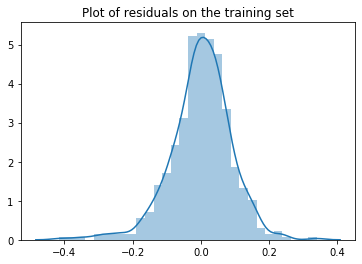

In [59]:
lr_model = lr_model_train(supported_cols)

# Get training data for supported cols
X_train_supportedcols = X_train[supported_cols]

# Add constant 
X_train_supportedcols_sm = sm.add_constant(X_train_supportedcols)

# Predict the y_train using the model
y_train_pred = lr_model.predict(X_train_supportedcols_sm)

# Get the residuals
res = y_train - y_train_pred

# Plot distplot for the residuals
sns.distplot(res)
plt.title("Plot of residuals on the training set")
plt.show()


Qualitative analysis on the distribution of residuals of the training set:
- The distribution of residuals is a normal distribution
- The distribution of residuals is centered around 0

## Check if residuals are independent

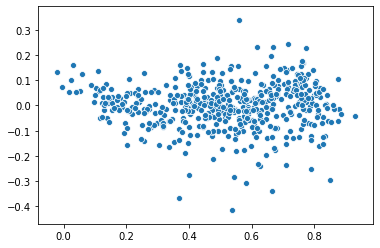

In [60]:
sns.scatterplot(x=y_train_pred, y=res)
plt.show()

Qualitative analysis of scatter plot of residuals:
- Centered around 0
- No relation with the y_train_pred
- The variance is also almost similar for every predicted y. It clearly shows __homoscedacity__
- It is independent

## Qualitative analysis of residuals 
- The error terms are normally distributed and centered around 0
- The residuals are independent and exhibit __homoscedacity__.
- Hence the model satisfies all the assumptions for linear regression.

# Checkpoint 6: Residual analysis

----------------------------------------------------------------------
----------------------------------------------------------------------
# Prediction and analysis
- Predict the target variable on the test set
- Calculate R-squared score on the test set

## Predict the target variable on the test set

In [61]:
# Get testing data for the supported variables
X_test_supportedcols = X_test[supported_cols]

# Add constant
X_test_supportedcols_sm = sm.add_constant(X_test_supportedcols)

# Predict y_test
y_test_pred = lr_model.predict(X_test_supportedcols_sm)

# Get residuals for test set
res_test = y_test - y_test_pred

## Calculate R-squared score on the test set

In [62]:
# test set
r2_test = round(r2_score(y_true=y_test, y_pred=y_test_pred), 2)
r2_test

0.8

In [63]:
# train set
r2_train = round(r2_score(y_true=y_train, y_pred=y_train_pred), 2)
r2_train

0.84

In [64]:
# Difference between r2_train and r2_test
round(r2_train - r2_test, 2)

0.04

### The calculated R-square for the model on the test set: 0.8

In [65]:
coeff = round(lr_model.params, 3)
coeff.sort_values()

Light Rain   -0.287
windspeed    -0.150
holiday      -0.104
Cloudy       -0.083
Tuesday      -0.048
August        0.051
summer        0.100
September     0.114
winter        0.138
const         0.139
yr            0.232
temp          0.518
dtype: float64

# Checkpoint 7: Prediction and analysis

----------------------------------------------------------------------
----------------------------------------------------------------------
# Summary:
- R-square on train set: 0.84
- R-square on test set: 0.8
- Difference between R-square values of train and test: 0.04 

__Equation of best fitted line__:
$ cnt = 0.139 + 0.232 \times yr - 0.104 \times holiday - 0.15 \times windspeed + 0.1 \times summer + 0.138 \times winter + 0.051 \times August + 0.114 \times September - 0.048 \times Tuesday - 0.083 \times Cloudy - 0.287 \times Light Rain + 0.518 \times temp $
